In [22]:
import sys
sys.path.append('/public/src')
from factor_evaluation_server import FactorEvaluation,DataService # type: ignore
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

In [23]:
ds=DataService()
df=ds['ETHUSDT_15m_2020_2025']['2021-10-01':]

In [24]:
evaluator=FactorEvaluation(df=df,future_return_periods=10)

# 定义因子！

In [25]:
def factor(df, window=94):
    # 复制数据避免修改原始数据
    df = df.copy()
    
    # 1. 向量化计算基础指标
    df['range'] = (df['high'] - df['low']) / df['open']
    df['fractal'] = df['range'].rolling(5).std() / df['range'].rolling(20).std().replace(0, 1e-5)
    df['is_up'] = (df['close'] > df['open']).astype(int)
    df['is_down'] = (df['close'] < df['open']).astype(int)
    
    # 2. 向量化重心计算
    def vectorized_center(group, direction):
        dir_col = f'is_{direction}'
        # 获取分组索引和权重
        idx = group.index
        weights = group['fractal'] * group['volume']
        mask = (group[dir_col] == 1)
        
        # 向量化计算
        cum_weights = weights.where(mask, 0).cumsum()
        cum_weighted_idx = (pd.Series(range(len(group)), index=idx)
                          .where(mask, 0) * weights).cumsum()
        
        # 计算重心并处理边界条件
        center = cum_weighted_idx / cum_weights
        center.iloc[:4] = np.nan  # 前4个点不计算
        return center
    
    # 按日分组并行计算
    df['G_u'] = (df.groupby(pd.Grouper(freq='D'))
                 .apply(lambda g: vectorized_center(g, 'up'))
                 .reset_index(level=0, drop=True))
    
    df['G_d'] = (df.groupby(pd.Grouper(freq='D'))
                 .apply(lambda g: vectorized_center(g, 'down'))
                 .reset_index(level=0, drop=True))
    
    # 3. 滚动窗口向量化
    df['avg_fractal'] = df['fractal'].rolling(24, min_periods=12).mean()
    
    # 预计算有效索引
    valid_idx = df.dropna(subset=['G_u', 'G_d', 'avg_fractal']).index
    regression_data = np.full(len(df), np.nan)
    
    # 4. 滚动回归优化
    # 预计算累积矩阵 (X'X 和 X'y)
    X = df[['G_u', 'avg_fractal']].values
    y = df['G_d'].values
    
    # 初始化存储
    XTX = np.zeros((len(df), 2, 2))
    XTy = np.zeros((len(df), 2))
    valid_mask = ~np.isnan(X).any(axis=1) & ~np.isnan(y)
    
    # 批量计算外积
    for i in range(len(df)):
        if valid_mask[i]:
            x_vec = X[i]
            XTX[i] = np.outer(x_vec, x_vec)
            XTy[i] = x_vec * y[i]
    
    # 计算累积和
    cum_XTX = np.nancumsum(XTX, axis=0)
    cum_XTy = np.nancumsum(XTy, axis=0)
    
    # 5. 向量化滚动回归
    for i in range(window, len(df)):
        start = i - window
        
        # 使用累积差计算窗口矩阵
        window_XTX = cum_XTX[i-1] - (cum_XTX[start-1] if start > 0 else 0)
        window_XTy = cum_XTy[i-1] - (cum_XTy[start-1] if start > 0 else 0)
        
        # 检查有效数据点数
        window_points = np.count_nonzero(valid_mask[start:i])
        if window_points < 10:
            continue
            
        try:
            # 求解线性方程组
            coeffs = np.linalg.solve(window_XTX, window_XTy)
            pred = X[i] @ coeffs
            residual = y[i] - pred
            regression_data[i] = residual * df['avg_fractal'].iloc[i]
        except np.linalg.LinAlgError:
            continue
    
    # 6. 后处理
    factor_series = pd.Series(-regression_data, index=df.index)
    factor_series = factor_series.fillna(0)
    
    factor_series[np.abs(factor_series) < 1.6] = 0
    
    return factor_series

# 测试因子表现


📊 单币种 (single) 详细评估结果:
--------------------------------------------------
🔗 相关性分析:
   IC (Pearson): 0.027313
   Rank_IC (Spearman): 0.009464
📊 信息比率:
   IR: 0.379018
   有效分组数: 8
📊 因子分布:
📋 数据概况:
   数据长度: 131035
   因子列: factor
   收益率列: future_return
   未来收益周期: 10
--------------------------------------------------

🖼️  单币种 (single) 图片展示:
----------------------------------------


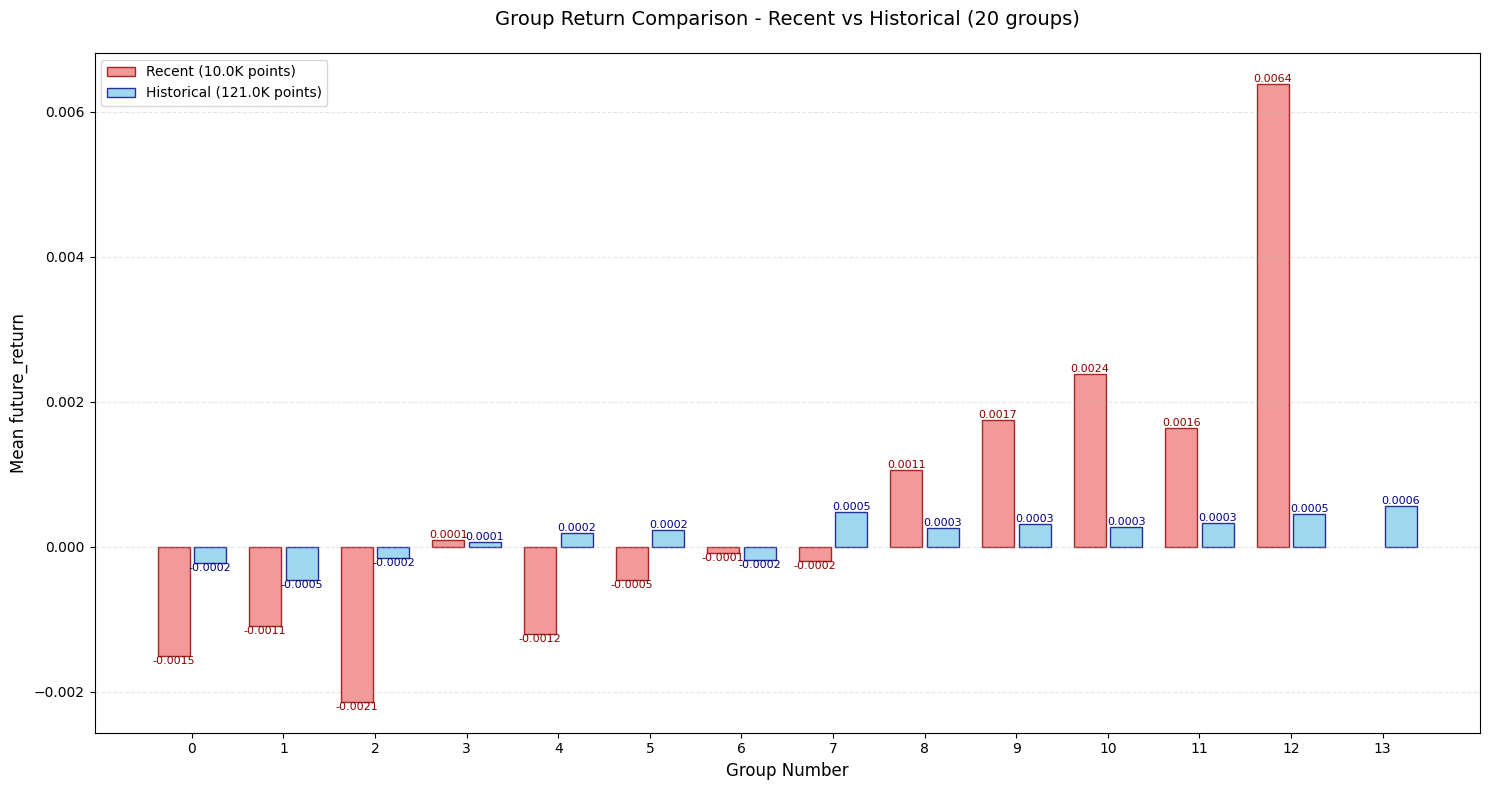

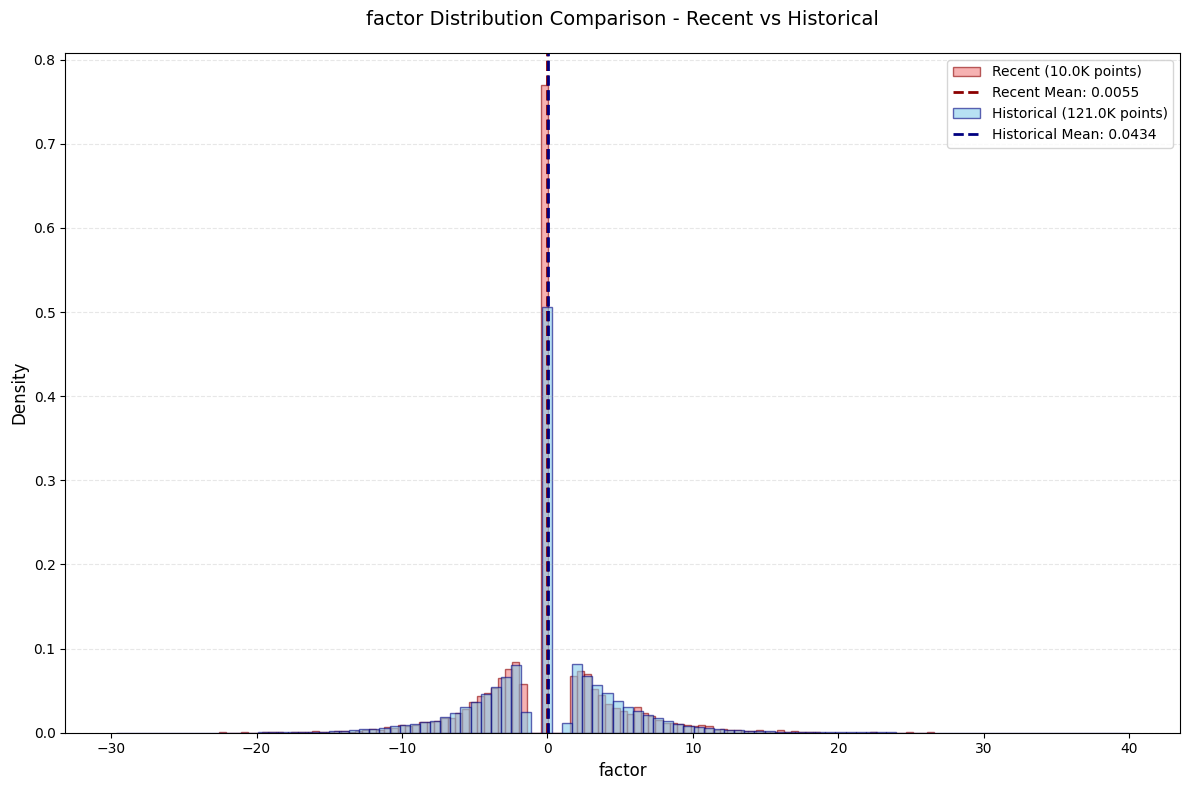

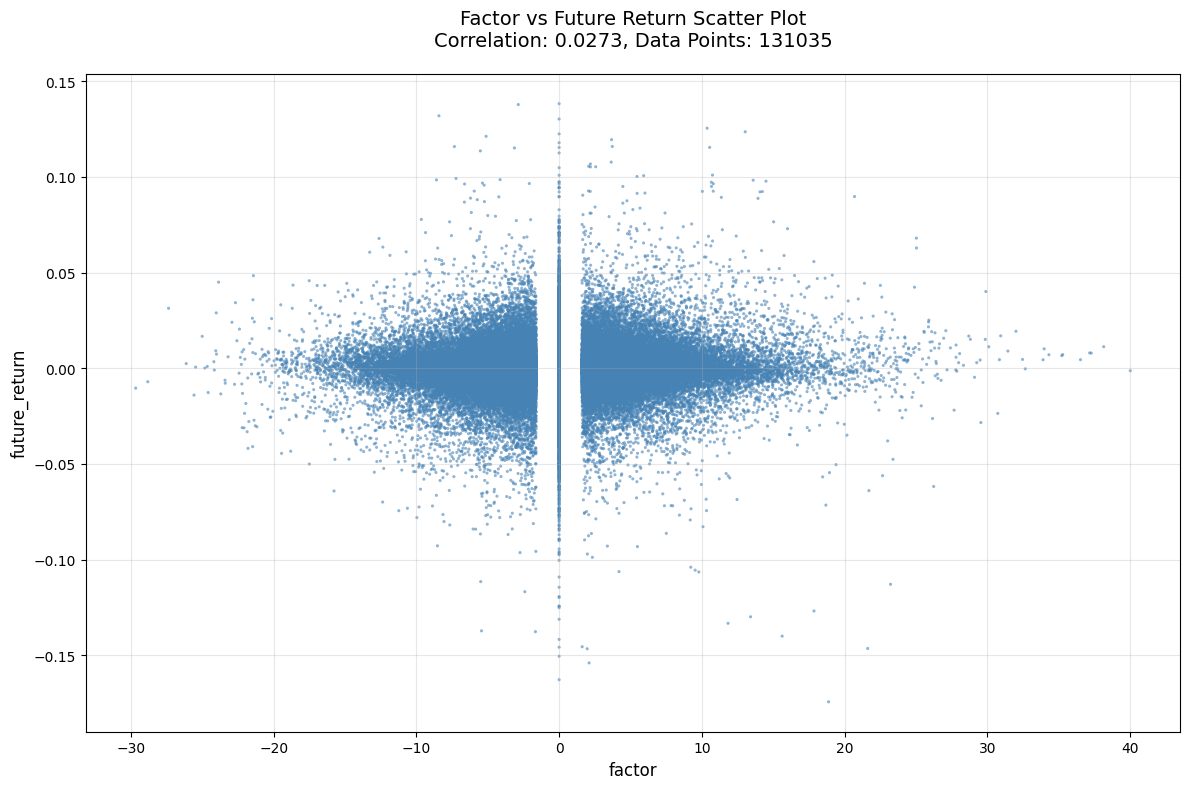

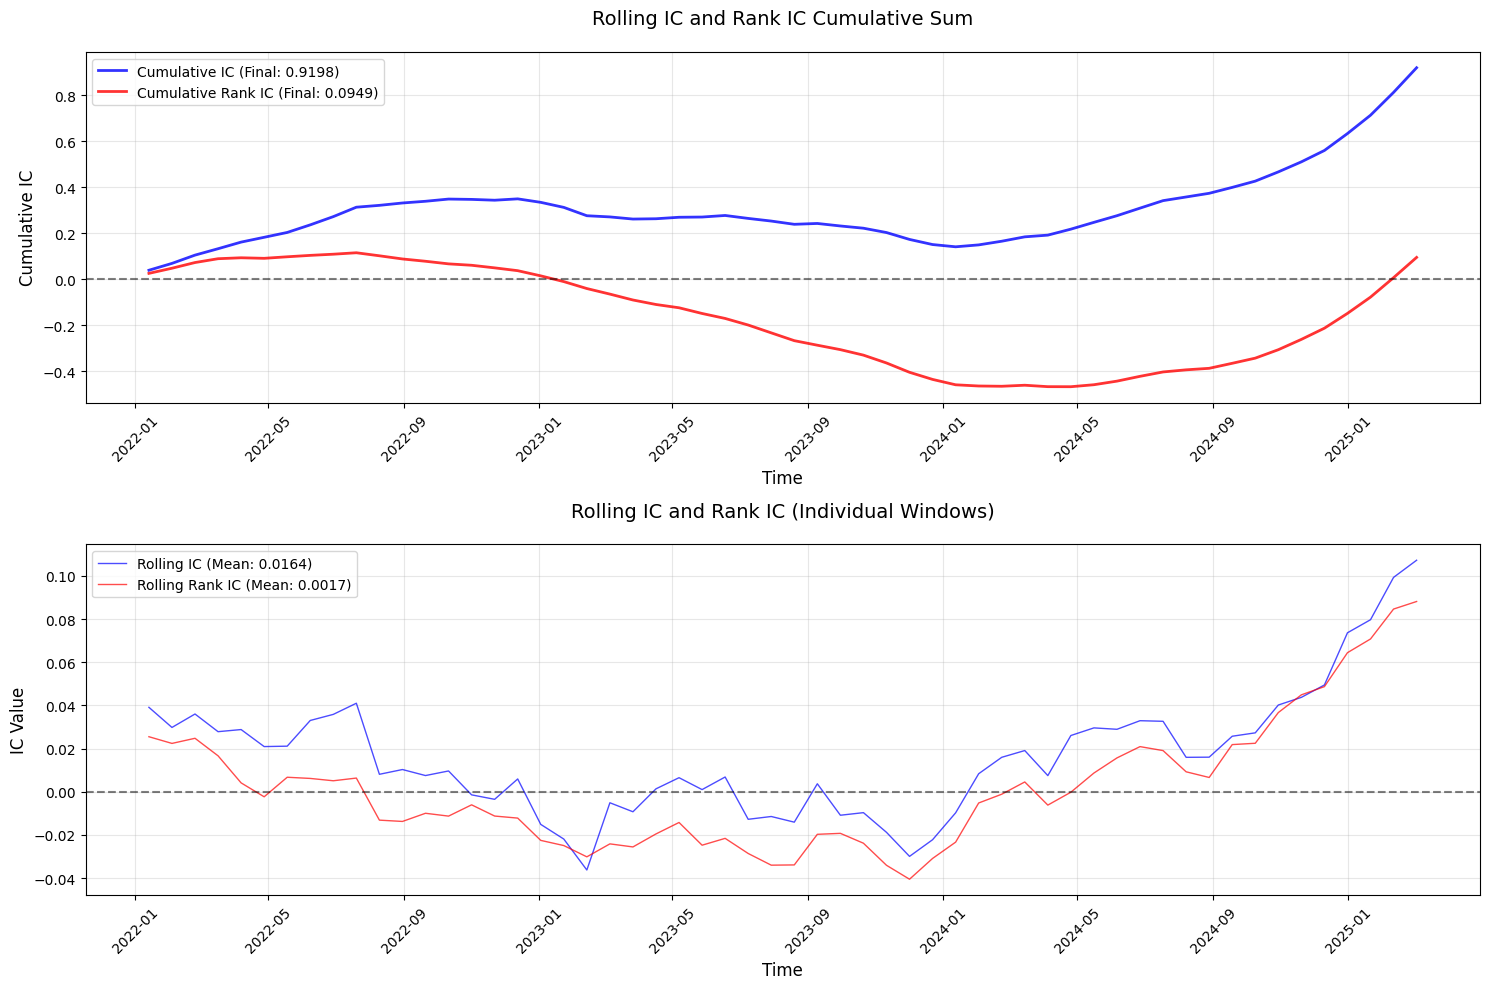

✅ 已显示 4 个图片
----------------------------------------


In [26]:
evaluator.set_factor(
    factor_func=lambda df: factor(df),
    factor_name='factor'
)

result=evaluator.run_full_evaluation(run_stationarity_test=False)

In [27]:
result['information_ratio']['group_correlations']
# 这表示不同分组之间的相关性，通常用于评估因子在不同市场状态下的表现一致性。
# 如果相关性较高，说明因子在不同市场状态下表现一致；如果相关性较低，说明因子在不同市场状态下表现差异较大。

[-0.01690796479513809,
 0.017082174178146198,
 0.0015363590771937847,
 0.0048825823401946414,
 -0.0102667659819026,
 0.009478070331710262,
 0.0028196744056216494,
 0.04323663360510031]

In [28]:
print(result)

{'correlation_analysis': {'IC': 0.02731286940144614, 'Rank_IC': 0.009464318952115096}, 'information_ratio': {'IR': 0.3790177409362612, 'group_correlations': [-0.01690796479513809, 0.017082174178146198, 0.0015363590771937847, 0.0048825823401946414, -0.0102667659819026, 0.009478070331710262, 0.0028196744056216494, 0.04323663360510031], 'n_groups': 8}, 'group_analysis': {'group_stats':        val_min  val_max  val_mean  return_mean  return_std  count
group                                                            
0     -29.6643  -7.8114  -10.8188      -0.0003      0.0134   6552
1      -7.8113  -5.4966   -6.5002      -0.0005      0.0127   6552
2      -5.4966  -4.2037   -4.8063      -0.0003      0.0123   6552
3      -4.2037  -3.2444   -3.7009      -0.0000      0.0112   6551
4      -3.2443  -2.4907   -2.8543       0.0001      0.0113   6552
5      -2.4904  -1.8699   -2.1712       0.0001      0.0114   6552
6      -1.8697   0.0000   -0.1080      -0.0002      0.0111  49503
7       1.6002   1.8